In [1]:
import sys
sys.path.append('../src/')

In [ ]:
import os.path as osp

import torch
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score

import torch_geometric.transforms as T
from torch_geometric.datasets import Planetoid

from torch_geometric import seed_everything

import numpy as np
import pandas as pd

import networkx as nx
from torch_geometric.utils.convert import from_networkx

from tqdm import tqdm

from model_grn import GRNGNN ,prediction_dgl
from explainer_grn import PaGELink
from metrics import deletion_curve_edges, deletion_curve_features, linear_area_score
from utils_eval import ws_graph_model, sbm_graph_model, get_computation_graph_as_nx
from utils_eval import get_explanation
from plotting import visualize_explanation

from torch_geometric.utils import k_hop_subgraph

from matplotlib import pyplot as plt
import seaborn as sb

In [ ]:
from data_grn_processing import load_grn_dataset, load_grn_dataset_dgl
from collections import defaultdict
from utils import src_tgt_khop_in_subgraph

In [7]:
sb.set_theme(context='paper', style='white', font_scale=1.5, palette=None)

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
seed = 0


In [ ]:
# DGL 그래프에서 feature dimension 가져오기 (feat이 아닌 모든 ndata 속성 사용)
def get_in_dim(mp_g):
    """
    DGL 그래프에서 모든 노드 feature의 총 차원을 계산하는 함수
    """
    node_feats = []
    for key in mp_g.ndata.keys():  # 모든 노드 feature 속성 확인
        feat = mp_g.ndata[key]  # 해당 feature 텐서 가져오기
        if len(feat.shape) == 2:  # (num_nodes, feature_dim) 형태일 경우만 추가
            node_feats.append(feat.shape[1])
    
    if not node_feats:
        raise ValueError("No valid node features found in graph! Check ndata.")

    return sum(node_feats)  # 모든 feature 차원을 더해서 총 in_dim 반환


In [12]:
seed_everything(seed)


In [ ]:
seed_everything(seed)


processed_g = load_grn_dataset_dgl("datasets","Ecoli1_basic_graph", val_ratio=0.2, test_ratio=0.3)[1]
mp_g, train_pos_g, train_neg_g, val_pos_g, val_neg_g, test_pos_g, test_neg_g = [g.to(device) for g in processed_g]

try:
    in_dim = get_in_dim(mp_g)
except KeyError:
    raise ValueError("Graph does not contain 'feat' in node features. Ensure features are properly assigned.")


model = GRNGNN(in_channels=in_dim, hidden1_channels=128, hidden2_channels=64, out_channels=32, dec='dot_sum', af_val='F.silu', num_layers=4, epoch=20, aggr='sum', var='ChebConv')
state = torch.load(f'saved_models/basic_data_Ecoli1_InSilicoSize100_model.pth', map_location='cuda')
model.load_state_dict(state) 

pagelink = PaGELink(model, 
                    lr=0.01,
                    alpha=1.0, 
                    beta=1.0, 
                    num_epochs=20,
                    log=True,
                    af_val='F.silu').to(device)
seed_everything(0)


Epoch: 20, Loss: 0.6199, Val: 0.6495, Test: 0.6294
Epoch: 40, Loss: 0.5394, Val: 0.7818, Test: 0.7566
Epoch: 60, Loss: 0.5146, Val: 0.7911, Test: 0.7751


In [ ]:

test_src_nids, test_tgt_nids = test_pos_g.edges()
comp_graphs = defaultdict(list)
comp_g_labels = defaultdict(list)

i = 4
# Get the k-hop subgraph
src_nid, tgt_nid = test_src_nids[i], test_tgt_nids[i]
comp_g_src_nid, comp_g_tgt_nid, comp_g, comp_g_feat_nids = src_tgt_khop_in_subgraph( src_nid,
                                                                                     tgt_nid,
                                                                                            mp_g,
                                                                                            num_hops=2)

with torch.no_grad():
    pred = prediction_dgl(model, comp_g, af_val='F.silu', dec='dot_sum')


In [7]:
i = 1
edge_label_index = val_data.edge_label_index[:, [i]]
source_node, target_node = edge_label_index.numpy()[:, 0]

target = val_data.edge_label[i].item()
if sigmoid:
        pred = model(train_data.x, train_data.edge_index, edge_label_index).sigmoid().item()
else:
    pred = model(train_data.x, train_data.edge_index, edge_label_index).item()

if target==1 and int(pred>0.5)==target:
    source_node, target_node, pred, target

    explanation, edge_mask, node_mask = get_explanation(
        explainer, model, train_data, edge_label_index, return_type=return_type
    )

    computation_graph = get_computation_graph_as_nx(source_node, target_node, train_data)

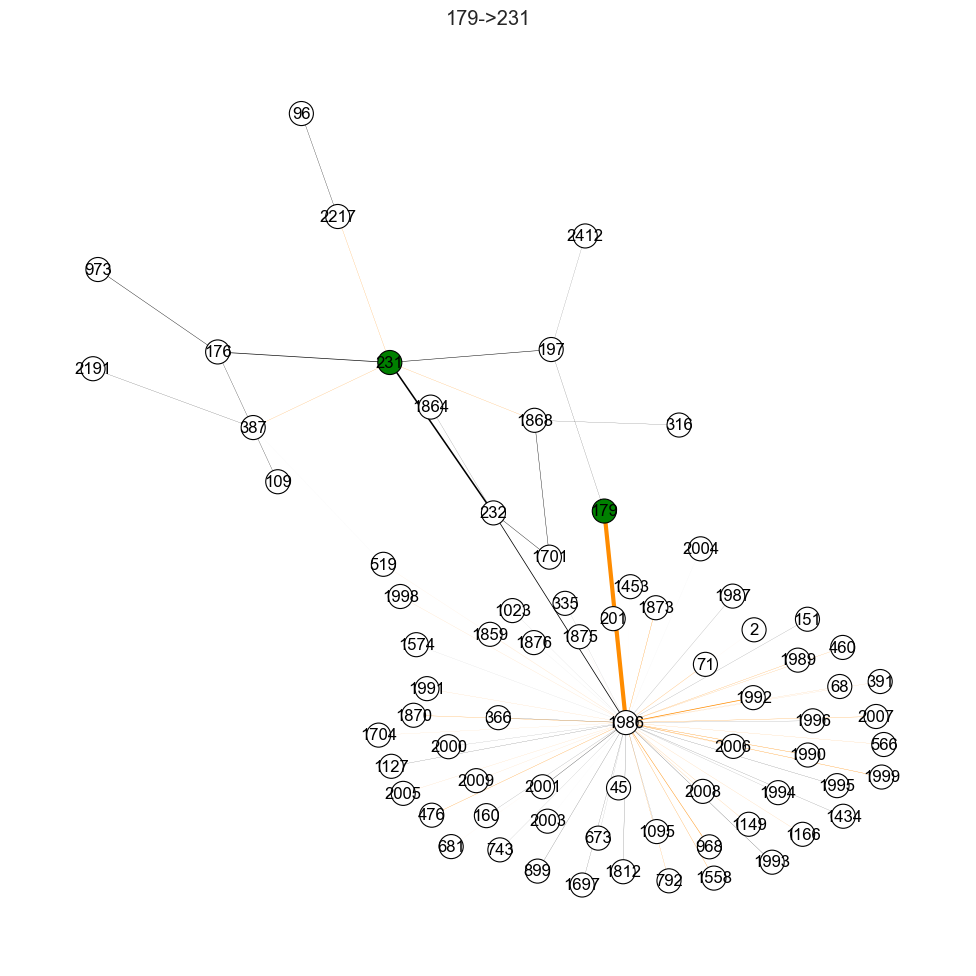

In [8]:
fig = visualize_explanation(computation_graph, train_data.edge_index, edge_mask, source_node, target_node)
plt.tight_layout()
plt.savefig(f"../paper/figs/{graph_model}_{model_name}_{explainer}_{decoder}_explanation_example.png")

In [9]:
subset, sub_edge_index, sub_mapping, sub_edge_mask = k_hop_subgraph(
        [source_node, target_node], 
        2, 
        train_data.edge_index)

#  Edges
deletion_curve = deletion_curve_edges(
    model,
    train_data.x,
    sub_edge_index,
    edge_label_index,
    edge_mask[sub_edge_mask],
    sigmoid=sigmoid
)

#  Edges random
deletion_curve_rnd = deletion_curve_edges(
    model,
    train_data.x,
    sub_edge_index,
    edge_label_index,
    edge_mask[sub_edge_mask],
    sigmoid=sigmoid,
    sorting='random'
)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:56<00:00,  2.84s/it]


In [10]:
edge_score = linear_area_score(deletion_curve)

In [11]:
edge_score

0.5420408624775718

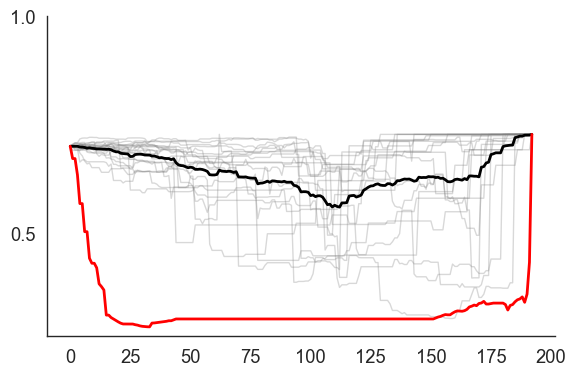

In [12]:
fig, ax = plt.subplots(figsize=(6, 4))
plt.plot(deletion_curve_rnd.T, alpha=.3, c='grey', lw=1)
plt.plot(deletion_curve_rnd.mean(axis=0), c='black', lw=2)
plt.plot(deletion_curve, c='r', lw=2)
ax.set_yticks([0.5, 1])
sb.despine()
plt.tight_layout()

In [13]:
#  Features / Nodes
feature_mean_mask = node_mask.mean(axis=0)
node_mean_mask = node_mask.mean(axis=1)
feature_base_values = train_data.x.mean(dim=0)

feature_deletion_curve = deletion_curve_features(
    model,
    train_data.x,
    sub_edge_index,
    edge_label_index,
    feature_mean_mask,
    feature_base_values,
    sigmoid=sigmoid
)

#  Features / Nodes
feature_mean_mask = node_mask.mean(axis=0)
node_mean_mask = node_mask.mean(axis=1)
feature_base_values = train_data.x.mean(dim=0)

feature_deletion_curve_rnd = deletion_curve_features(
    model,
    train_data.x,
    sub_edge_index,
    edge_label_index,
    feature_mean_mask,
    feature_base_values,
    sigmoid=sigmoid, 
    sorting='random'
)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [06:19<00:00, 18.99s/it]


In [14]:
feature_score = linear_area_score(feature_deletion_curve)

In [15]:
feature_score

0.5627308208978637

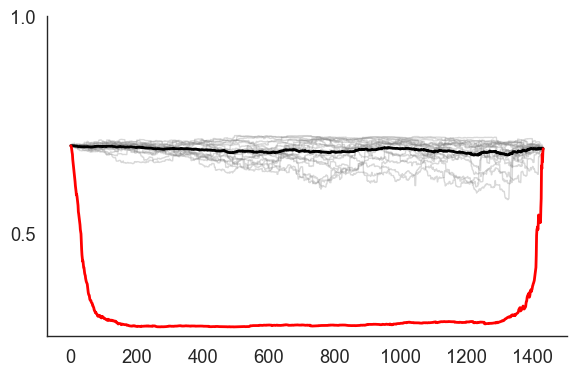

In [16]:
fig, ax = plt.subplots(figsize=(6, 4))
plt.plot(feature_deletion_curve_rnd.T, alpha=.3, c='grey', lw=1)
plt.plot(feature_deletion_curve_rnd.mean(axis=0), c='black', lw=2)
plt.plot(feature_deletion_curve, c='r', lw=2)
ax.set_yticks([0.5, 1])
sb.despine()
plt.tight_layout()